
#Lab5 : Lexical Semantics

Authors:<br>
* Ramón Mateo Navarro
* Benet Manzanares Salor

##Installation ans imports

In [ ]:
import numpy as np

import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet as wn
nltk.download('wordnet_ic')
from nltk.corpus import wordnet_ic as wnic

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet_ic to /root/nltk_data...
[nltk_data]   Package wordnet_ic is already up-to-date!


## Data

In [ ]:
# Word set
words_pos_pairs = [('the','DT'), ('man','NN'), ('swim','VB'), ('with', 'PR'), ('a', 'DT'),
('girl','NN'), ('and', 'CC'), ('a', 'DT'), ('boy', 'NN'), ('whilst', 'PR'),
('the', 'DT'), ('woman', 'NN'), ('walk', 'VB')]
num_words = len(words_pos_pairs)

# PoS tags: https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# WordNet tags: https://stackoverflow.com/questions/34831167/wordnet-what-does-n-and-the-number-represent
PoS_to_WN_dict = {    
    "NN": "n",
    "VB": "v",
    "DT": None,
    "PR": None,
    "CC": None
}

##Experiment

### Computing

In [ ]:
# Functions
def get_most_frequent_synset(word_pos_pair):
  synset = None
  word, pos = word_pos_pair
  category_str = PoS_to_WN_dict[pos]
  if category_str != None:
    synset = wn.synset(f"{word}.{category_str}.01")
  
  return synset, category_str

def get_synsets(words_pos_pairs):
  synsets = []
  for word_pos_pair in words_pos_pairs:
    synset, category_str = get_most_frequent_synset(word_pos_pair)
    if synset is not None and category_str is not None:
      synsets.append(synset)
  
  return synsets

In [ ]:
# Obtain synsets and corresponding words
synsets = get_synsets(words_pos_pairs)
words = [x.lemma_names()[0] for x in synsets]
num_synsets = len(synsets)

# Results matrices allocation
LCSs = np.full((num_synsets, num_synsets), None)
similarities = np.zeros((num_synsets, num_synsets, 4), dtype=np.float)

# LCSs and simmilarities computation
brown_ic = wnic.ic('ic-brown.dat')
for i, s1 in enumerate(synsets):
  for j, s2 in enumerate(synsets):
    if s1.pos() == s2.pos():
      # Least common subsumer
      lcs = s1.lowest_common_hypernyms(s2)
      if lcs is not None:
        LCSs[i, j] = lcs[0]

      # Similarities
      similarities[i, j, 0] = s1.path_similarity(s2)
      similarities[i, j, 1] = s1.lch_similarity(s2) / s1.lch_similarity(s1) # Normalize with the maximum similarity possible
      similarities[i, j, 2] = s1.wup_similarity(s2)
      similarities[i, j, 3] = s1.lin_similarity(s2, brown_ic)

### Plotting

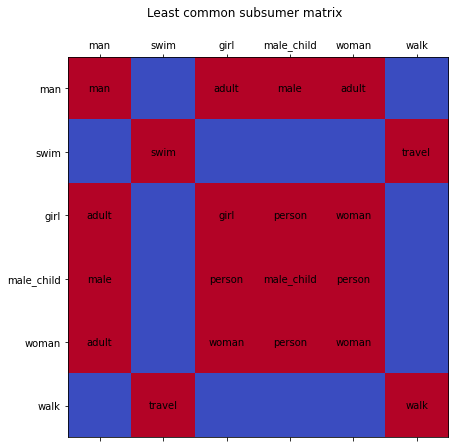

In [ ]:
# Plot least common subsumer matrix
placeholder = np.zeros_like(LCSs, dtype=np.uint8)
labels = ['']+words

fig, ax = plt.subplots(figsize=(15, 7))
fig.suptitle("Least common subsumer matrix")
ax.matshow(placeholder, cmap="coolwarm")

for (i, j), synset in np.ndenumerate(LCSs):
  if synset is not None:
    placeholder[i, j] = 1
    word = synset.lemma_names()[0]
    ax.text(j, i, f"{word}", ha="center", va="center")

ax.matshow(placeholder, cmap="coolwarm")
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

fig.show()

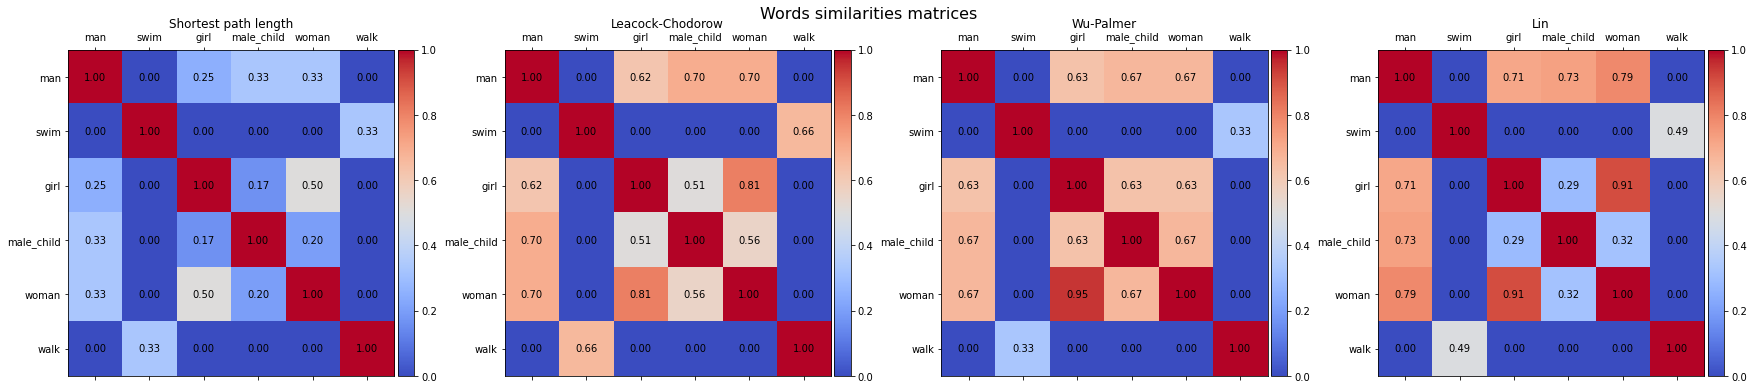

In [ ]:
# Plot words similarities matrices
similarities_funcs = ["Shortest path length", "Leacock-Chodorow", "Wu-Palmer", "Lin"]
labels = ['']+words

fig, ax = plt.subplots(1, len(similarities_funcs), figsize=(30, 6))
fig.suptitle("Words similarities matrices", fontsize=16)

for i, name in enumerate(similarities_funcs):
  divider = make_axes_locatable(ax[i])
  cax = divider.append_axes('right', size='5%', pad=0.05)

  mat = ax[i].matshow(similarities[:, :, i], cmap="coolwarm")
  for (j, k), value in np.ndenumerate(similarities[:, :, i]):
    ax[i].text(k, j, "{:0.2f}".format(value), ha="center", va="center")

  fig.colorbar(mat, cax=cax, orientation='vertical')
  ax[i].set_title(name)
  ax[i].set_xticklabels(labels)
  ax[i].set_yticklabels(labels)

fig.show()

## Conclusions

First, we want to note that the results obtained for the Least Common Subsumer operation and the Shortest Path Length, Wu-Palmer and Lin simmilarity measures are symetric, as expected. Nevertheless, the simmilarities obtained with the Leacock-Chodorow measure are not completely simmetric, although they must be (since the LCS and the corresponding depths are equal independently of the synsets order).Concretely, the anomalous asimmetric result is obtained for the girl-woman word pairs, with a simmilarity of 0.95 when is computed from girl to woman and 0.63 if computed from woman to girl.

* What similarity seems better?<br>
In our opinion, the best simmilarity metric is Lin. Out decision is based the fact that Lin, instead of "normalizing" using the depth (a discrete value) of the synsets in the WordNet ontology (which is subjective) as Leacock-Chodorow and Wu-Palmer do, uses the Information Content (more objective and continuous) of the synsets in the language (extracted from a presumable huge corpus). In other words, we consider that the frequency of occurrence of a synset provides a better and more granular approximation of word specificity than the depth in WordNet.